In [1]:
import pandas as pd
import numpy as np

# 数据准备

In [2]:
#load data
file_path='Concrete_Data.xls'
df=pd.read_excel(file_path,sheet_name=0)
df=df.sample(frac=1.0).reset_index(drop=True)
print(df.shape)
print(df.columns)

(1030, 9)
Index(['Cement (component 1)(kg in a m^3 mixture)',
       'Blast Furnace Slag (component 2)(kg in a m^3 mixture)',
       'Fly Ash (component 3)(kg in a m^3 mixture)',
       'Water  (component 4)(kg in a m^3 mixture)',
       'Superplasticizer (component 5)(kg in a m^3 mixture)',
       'Coarse Aggregate  (component 6)(kg in a m^3 mixture)',
       'Fine Aggregate (component 7)(kg in a m^3 mixture)', 'Age (day)',
       'Concrete compressive strength(MPa, megapascals) '],
      dtype='object')


# 数据清洗

In [3]:
for column in df.columns:
    if df[column].count()!=df.shape[0]:
        print('Missing data:')
        row=data[column][data[column].isnull().values==True].index.tolist()
        print('Missing data at：{}, row:{}'.format(column,row))
        df.drop(index=row)

In [4]:
#split X and y
#split X_test and y_test
X=df.iloc[:df.shape[0]*7//10,:df.shape[1]-1]
y=df.iloc[:df.shape[0]*7//10,df.shape[1]-1]
X_test=df.iloc[df.shape[0]*7//10:,:df.shape[1]-1]
y_test=df.iloc[df.shape[0]*7//10:,df.shape[1]-1]
print(X.shape,y.shape)
print(X_test.shape,y_test.shape)

(721, 8) (721,)
(309, 8) (309,)


In [5]:
#normalization
means=[]
stds=[]
for column in X.columns:
    means.append(X[column].mean())
    stds.append(X[column].std())
X-=means
X/=stds
X_test-=means
X_test/=stds

In [6]:
#convert to ndarray
X=X.values
y=y.values
X_test=X_test.values
y_test=y_test.values

In [7]:
#expand X and X_test with x0 where x0=1
X=np.hstack((np.ones((X.shape[0],1)),X))
X_test=np.hstack((np.ones((X_test.shape[0],1)),X_test))
print(X.shape,X_test.shape)

(721, 9) (309, 9)


# 模型搭建

In [8]:
def loss(y_pred,y):
    #y.shape-->m*1
    if(len(y_pred)!=len(y)):
        print("shape error!")
        return None
    return np.matmul((y-y_pred).T,y-y_pred)/2/len(y)

In [9]:
def gradientDescent(theta,X,y,X_test,y_test,num_epoch,learning_rate=0.1):
    #X.shape-->m*(n+1)
    #theta.shape-->(n+1)*1
    losses=[]
    test_losses=[]
    for epoch in range(num_epoch):
        #print('epoch',epoch)
        y_pred=np.matmul(X,theta)
        cost=loss(y_pred,y)
        losses.append(cost)
        #print('loss:',cost)
        grad=np.matmul(X.T,y_pred-y)/len(y)
        theta-=learning_rate*grad
        test_loss=loss(np.matmul(X_test,theta),y_test)
        #print('test_loss:',test_loss)
        test_losses.append(test_loss)
        #print('-------------------------------------')
    return [theta,losses,test_losses]

# 模型训练测试

In [10]:
#initialize theta
theta=np.random.rand(X.shape[1])
print(theta.shape)
print(theta)

(9,)
[0.45401378 0.4819389  0.36019922 0.38664285 0.5207294  0.36712185
 0.66539739 0.28381459 0.39874362]


In [11]:
#train
num_epoch=64
[theta,losses,test_losses]=gradientDescent(theta,X,y,X_test,y_test,num_epoch,learning_rate=0.1)

In [12]:
#test
y_pred=np.matmul(X_test,theta)
test_loss=loss(y_pred,y_test)
print('test_loss:',test_loss)

test_loss: 55.99758507018661


# 结果可视化

In [13]:
import matplotlib.pyplot as plt

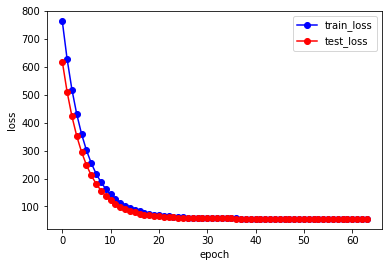

In [14]:
#visualize the training process
plt.plot(losses,'bo-',label='train_loss')
plt.plot(test_losses,'ro-',label='test_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

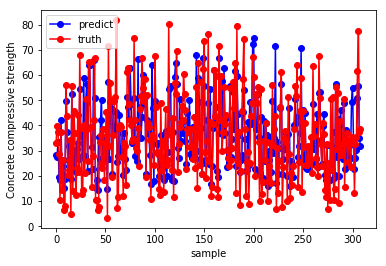

In [15]:
#visualize the test loss
plt.plot(y_pred,'bo-',label='predict')
plt.plot(y_test,'ro-',label='truth')
plt.xlabel('sample')
plt.ylabel('Concrete compressive strength')
plt.legend()
plt.show()

In [16]:
print(theta)

[35.94309095  7.98412752  4.40431761  1.30891453 -5.00109807  2.89408887
 -1.09375213 -1.6475178   7.02433378]


# 模型优化

## Regularization

In [17]:
#L2 regularization
def loss_re(y_pred,y,theta,lamb=1.0):
    #y.shape-->m*1
    #theta.shape-->(n+1)*1
    if(len(y_pred)!=len(y)):
        print("shape error!")
        return None
    return np.matmul((y-y_pred).T,y-y_pred)/2/len(y)+lamb/2*np.matmul(theta[1:].T,theta[1:])

In [18]:
def gradientDescent_re(theta,X,y,X_test,y_test,num_epoch,learning_rate=0.1,lamb=1.0):
    #X.shape-->m*(n+1)
    #theta.shape-->(n+1)*1
    losses=[]
    test_losses=[]
    for epoch in range(num_epoch):
        #print('epoch',epoch)
        y_pred=np.matmul(X,theta)
        cost=loss_re(y_pred,y,theta,lamb)
        losses.append(cost)
        #print('loss:',cost)
        theta_for_re=theta.copy()
        theta_for_re[0]=0
        grad=np.matmul(X.T,y_pred-y)/len(y)+lamb*theta_for_re
        theta-=learning_rate*grad
        test_loss=loss(np.matmul(X_test,theta),y_test)
        #print('test_loss:',test_loss)
        test_losses.append(test_loss)
        #print('-------------------------------------')
    return [theta,losses,test_losses]

In [19]:
#train
#try different lambda
learning_rate=0.1
lamb_list=[0.01,0.03,0.05,0.1,0.3,0.5,1,3,5,10,30]
last_losses_re=[]
losses_re_list=[]
test_losses_re_list=[]
theta_re_list=[]
for lamb in lamb_list:
    theta_re=np.random.rand(X.shape[1])
    num_epoch=64
    [theta_re,losses_re,test_losses_re]=gradientDescent_re(theta_re,X,y,X_test,y_test,num_epoch,learning_rate,lamb)
    last_losses_re.append(losses_re[-1])
    theta_re_list.append(theta_re)
    losses_re_list.append(losses_re)
    test_losses_re_list.append(test_losses_re)

In [20]:
best_index=np.argmin(last_losses_re)
best_lamb=lamb_list[best_index]
print(best_lamb)

0.01


In [21]:
losses_re=losses_re_list[best_index]
test_losses_re=test_losses_re_list[best_index]
theta_re=theta_re_list[best_index]

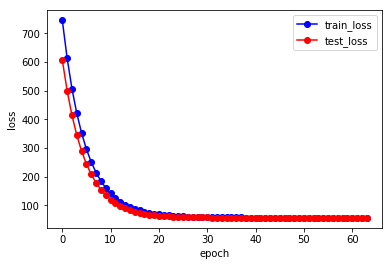

In [22]:
#visualize the training process
plt.plot(losses_re,'bo-',label='train_loss')
plt.plot(test_losses_re,'ro-',label='test_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [23]:
#test
y_pred_re=np.matmul(X_test,theta_re)
test_loss_re=loss(y_pred_re,y_test)
print('test_loss:',test_loss_re)

test_loss: 56.02370237183716


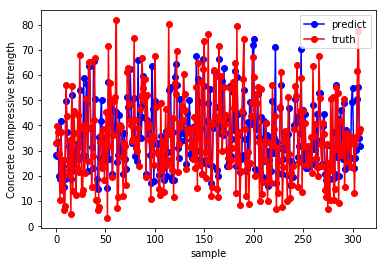

In [24]:
#visualize the test loss
plt.plot(y_pred_re,'bo-',label='predict')
plt.plot(y_test,'ro-',label='truth')
plt.xlabel('sample')
plt.ylabel('Concrete compressive strength')
plt.legend()
plt.show()

In [25]:
print(theta_re)

[35.94358357  7.92374303  4.36196915  1.28929556 -4.94782562  2.87091033
 -1.09321039 -1.62427689  6.94182326]


## Expand feature

In [26]:
#create new features
X_ef=X.copy()
X_test_ef=X_test.copy()
num_feature=X.shape[1]
for i in range(1,num_feature):
    for j in range(i+1,num_feature):
        new_feature=X[:,i]*X[:,j]
        X_ef=np.hstack((X_ef,new_feature[:,None]))
        new_feature=X_test[:,i]*X_test[:,j]
        X_test_ef=np.hstack((X_test_ef,new_feature[:,None]))
print(X_ef.shape,X_test_ef.shape)

(721, 37) (309, 37)


In [27]:
#train
#try different lambda
learning_rate=0.1
lamb_list=[0.01,0.03,0.05,0.1,0.3,0.5,1,3,5,10,30]
last_losses_ef=[]
losses_ef_list=[]
test_losses_ef_list=[]
theta_ef_list=[]
for lamb in lamb_list:
    theta_ef=np.random.rand(X_ef.shape[1])
    num_epoch=64
    [theta_ef,losses_ef,test_losses_ef]=gradientDescent_re(theta_ef,X_ef,y,X_test_ef,y_test,num_epoch,learning_rate,lamb)
    last_losses_ef.append(losses_ef[-1])
    theta_ef_list.append(theta_ef)
    losses_ef_list.append(losses_ef)
    test_losses_ef_list.append(test_losses_ef)

In [28]:
best_index_ef=np.argmin(last_losses_ef)
best_lamb_ef=lamb_list[best_index_ef]
print(best_lamb_ef)

0.01


In [29]:
losses_ef=losses_ef_list[best_index_ef]
test_losses_ef=test_losses_ef_list[best_index_ef]
theta_ef=theta_ef_list[best_index_ef]

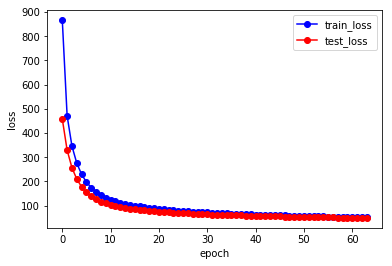

In [30]:
#visualize the training process
plt.plot(losses_ef,'bo-',label='train_loss')
plt.plot(test_losses_ef,'ro-',label='test_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [31]:
#test
y_pred_ef=np.matmul(X_test_ef,theta_ef)
test_loss_ef=loss(y_pred_ef,y_test)
print('test_loss:',test_loss_ef)

test_loss: 49.376569551643655


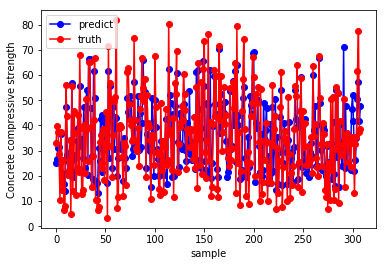

In [32]:
#visualize the test loss
plt.plot(y_pred_ef,'bo-',label='predict')
plt.plot(y_test,'ro-',label='truth')
plt.xlabel('sample')
plt.ylabel('Concrete compressive strength')
plt.legend()
plt.show()

In [33]:
print(theta_ef)

[28.71616641  7.58862807  3.60788893  1.23898154 -4.71800851  2.45690416
 -1.27287758 -0.57483067  9.67462556 -3.87493269 -2.39431645 -3.43334411
  0.45166095 -3.43556768 -1.08925825 -0.40771326 -3.48155012 -2.11717847
  3.75440435 -3.75814403 -0.93313507  0.94835856 -1.04035046  1.91013707
 -1.62200281  1.5279685   0.91859427  0.26294251 -2.46554322 -1.88599584
 -0.4965205   1.31083615 -0.67643812  2.90244432 -0.56254733  1.71156727
  0.58575483]


## Normal equation

In [34]:
#normal equation method
#X.shape-->m*(n+1)
#y.shape-->m*1
theta_ne=np.matmul(np.matmul(np.linalg.pinv(np.matmul(X,X.T)),X).T,y)

In [35]:
#test
y_pred_ne=np.matmul(X_test,theta_ne)
test_loss_ne=loss(y_pred_ne,y_test)
print('test_loss:',test_loss_ne)

test_loss: 54.83873635767156


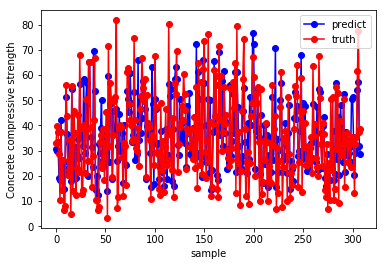

In [36]:
#visualize the test loss
plt.plot(y_pred_ne,'bo-',label='predict')
plt.plot(y_test,'ro-',label='truth')
plt.xlabel('sample')
plt.ylabel('Concrete compressive strength')
plt.legend()
plt.show()

In [37]:
print(theta_ne)

[35.98498262 12.81190882  9.04477591  5.81561814 -2.55128813  1.88406335
  1.68302463  2.33989237  7.34264402]
